In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install dataprep

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Dacon/Dacon_basic/전복나이/data/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
submission = pd.read_csv(path+'sample_submission.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1253 non-null   int64  
 1   Gender          1253 non-null   object 
 2   Lenght          1253 non-null   float64
 3   Diameter        1253 non-null   float64
 4   Height          1253 non-null   float64
 5   Whole Weight    1253 non-null   float64
 6   Shucked Weight  1253 non-null   float64
 7   Viscra Weight   1253 non-null   float64
 8   Shell Weight    1253 non-null   float64
 9   Target          1253 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 98.0+ KB


In [ ]:
train.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,1,M,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,15
1,2,I,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,8
2,3,I,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,18
3,4,M,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,13
4,5,I,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,6


In [ ]:
train_y = train['Target']
train = train.drop(['Target'], axis = 1)

In [ ]:
test.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight
0,1,F,0.595,0.470,0.155,1.121,0.4515,0.1780,0.1550
1,2,M,0.580,0.450,0.150,0.927,0.2760,0.1815,0.3600
2,3,I,0.260,0.205,0.070,0.097,0.0415,0.0190,0.0305
3,4,M,0.590,0.460,0.130,1.102,0.4550,0.2055,0.3300
4,5,F,0.595,0.465,0.140,1.113,0.5175,0.2440,0.3050


### Visualization

In [ ]:
from dataprep.eda import create_report
create_report(train)

### Preprocessing

In [ ]:
num = ['Lenght', 'Diameter', 'Height', 'Whole Weight',
       'Shucked Weight', 'Viscra Weight', 'Shell Weight']

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
cat_scaler = OneHotEncoder(sparse = False)
num_scaler = StandardScaler()

train_cat_scaled = cat_scaler.fit_transform(train[['Gender']])
test_cat_scaled = cat_scaler.transform(test[['Gender']])

train_num_scaled = num_scaler.fit_transform(train[num])
test_num_scaled = num_scaler.transform(test[num])

In [ ]:
train_scaled = np.c_[train_cat_scaled, train_num_scaled]
test_scaled = np.c_[test_cat_scaled, test_num_scaled]

In [ ]:
train_scaled.shape, test_scaled.shape

((1253, 10), (2924, 10))

### Modeling

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import mean_absolute_error

In [ ]:
! pip install optuna
import optuna
from optuna.samplers import TPESampler

In [ ]:
def objective_LGBM(trial):
    param = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 500,5000, step = 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 500, step = 10),
        "max_depth": trial.suggest_int("max_depth", 3,30),
        "min_child_samples": trial.suggest_int("min_child_samples",5,100, step = 5),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1 ),
        "random_state": trial.suggest_categorical("random_state", [2022]),
    }
    model = LGBMRegressor(**param)  
    
    x = train_scaled
    y = train_y

    scores = cross_val_score(model, x, y, scoring="neg_mean_absolute_error", cv = 5, n_jobs = - 1)
    mae  = np.mean(-scores)
    
    return mae

In [ ]:
sampler = TPESampler(seed=2022)
study = optuna.create_study(
    study_name="LGBM_optimizer",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective_LGBM, n_trials= 200)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

In [ ]:
optuna.visualization.plot_optimization_history(study)

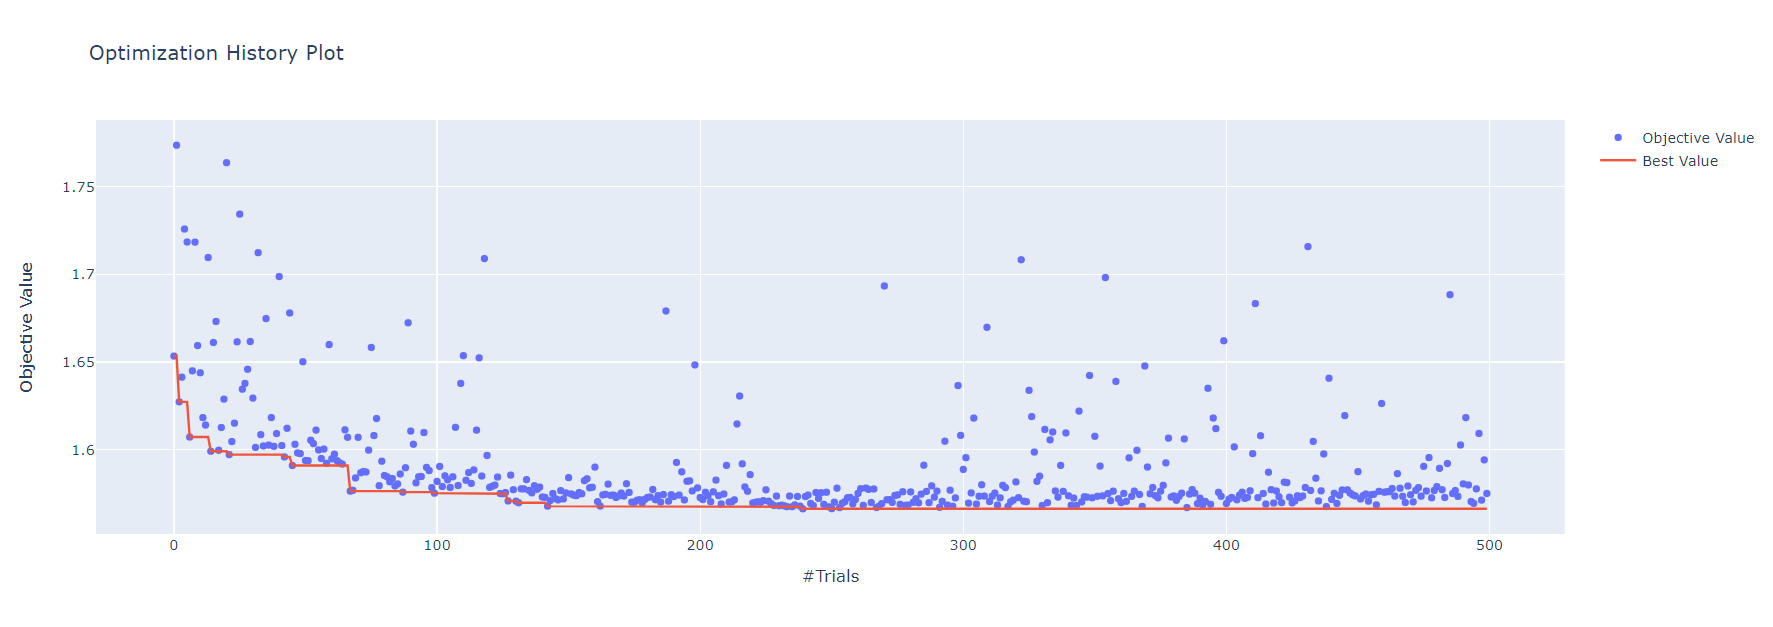

In [ ]:
study.best_trial.params

{'feature_fraction': 0.9,
 'lambda_l1': 15,
 'lambda_l2': 70,
 'learning_rate': 0.023429692580895077,
 'max_depth': 25,
 'min_child_samples': 10,
 'n_estimators': 500,
 'num_leaves': 290,
 'random_state': 2022}

In [ ]:
def objective_XGB(trial):
    param = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 500,5000, step = 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3,30),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.9, step=0.1 ),
        "random_state": trial.suggest_categorical("random_state", [2022]),
    }
    model = XGBRegressor(**param)  
    
    x = train_scaled
    y = train_y

    scores = cross_val_score(model, x, y, scoring="neg_mean_absolute_error", cv = 5, n_jobs = - 1)
    mae  = np.mean(-scores)
    
    return mae

In [ ]:
sampler = TPESampler(seed=2022)
study2 = optuna.create_study(
    study_name="XGB_optimizer",
    direction="minimize",
    sampler=sampler,
)
study2.optimize(objective_XGB, n_trials= 200)
print("Best Score:", study2.best_value)
print("Best trial:", study2.best_trial.params)

In [ ]:
optuna.visualization.plot_optimization_history(study2)

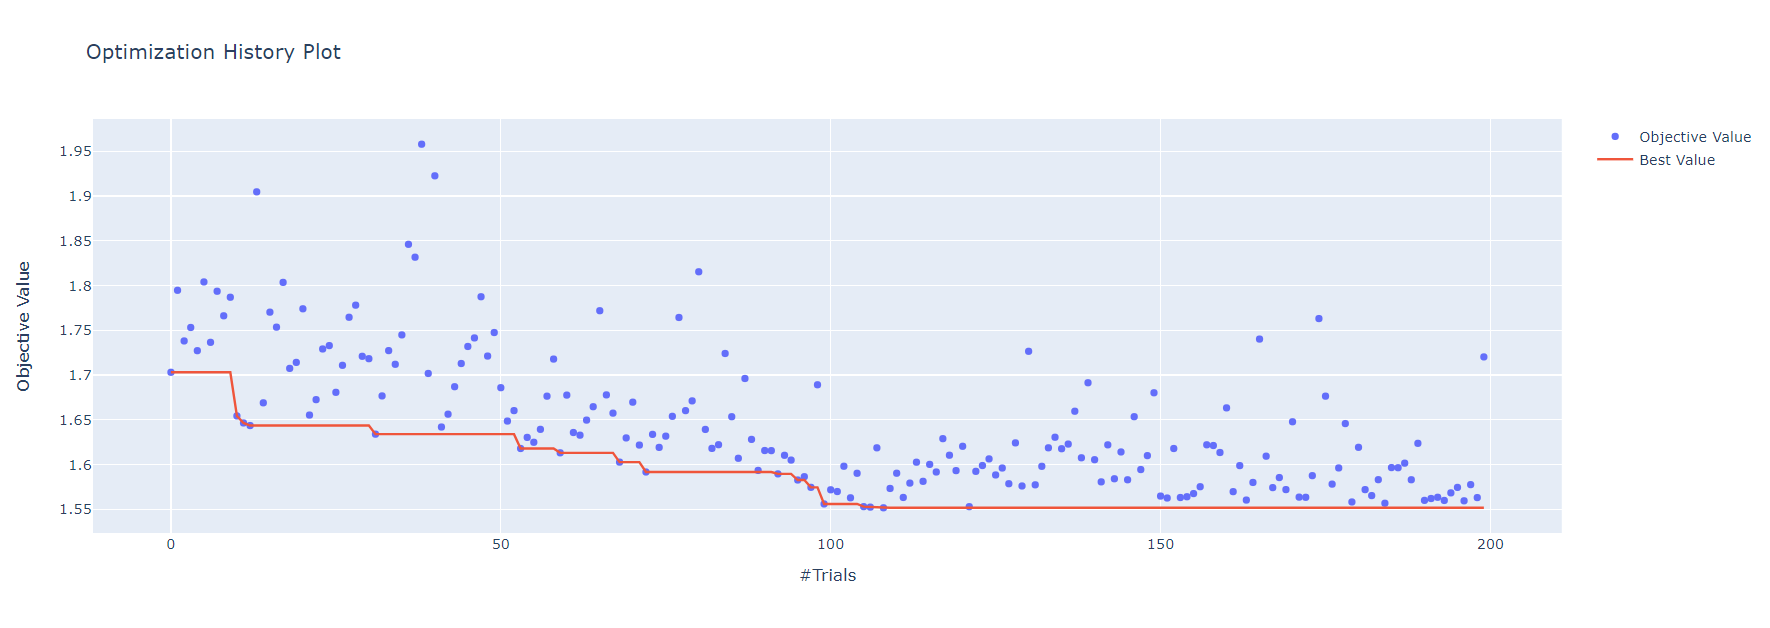

In [ ]:
study2.best_trial.params

{'feature_fraction': 0.7,
 'lambda_l1': 80,
 'lambda_l2': 95,
 'learning_rate': 0.006793719244917009,
 'max_depth': 19,
 'min_child_weight': 44,
 'n_estimators': 500,
 'random_state': 2022}

In [ ]:
def objective_RF(trial):
    param = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 500,2000, step = 10),
        'max_depth': trial.suggest_int('max_depth', 4, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
        "random_state": trial.suggest_categorical("random_state", [2022]),
    }
    model = RandomForestRegressor(**param)  
    
    x = train_scaled
    y = train_y

    scores = cross_val_score(model, x, y, scoring="neg_mean_absolute_error", cv = 5, n_jobs = - 1, error_score = 'raise')
    mae  = np.mean(-scores)
    
    return mae

In [ ]:
sampler = TPESampler(seed=2022)
study3 = optuna.create_study(
    study_name="RF_optimizer",
    direction="minimize",
    sampler=sampler,
)
study3.optimize(objective_RF, n_trials= 200)
print("Best Score:", study3.best_value)
print("Best trial:", study3.best_trial.params)

In [ ]:
optuna.visualization.plot_optimization_history(study3)

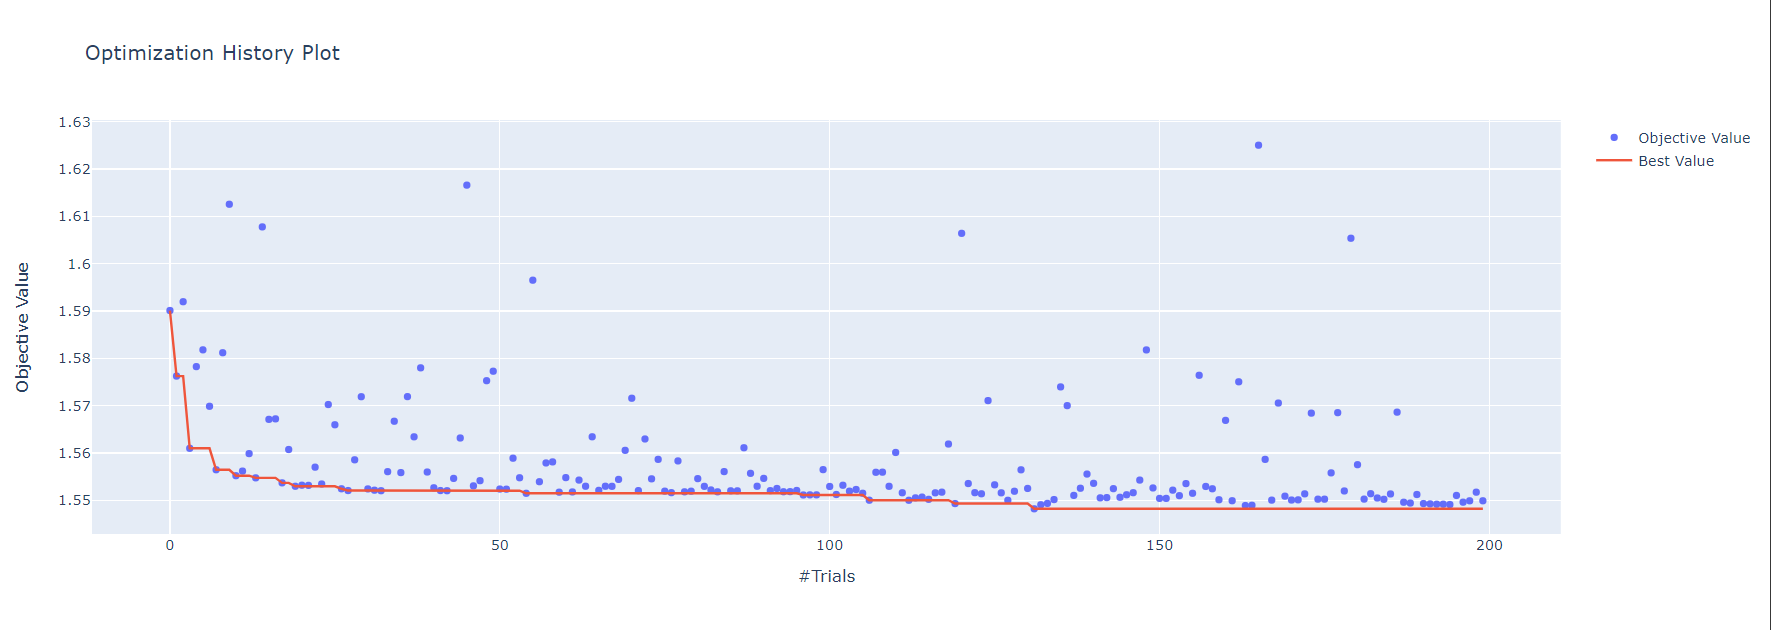

In [ ]:
study3.best_trial.params

{'max_depth': 7,
 'min_samples_leaf': 7,
 'min_samples_split': 19,
 'n_estimators': 1780,
 'random_state': 2022}

### Ensemble

#### 1.Lightgbm

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2022)

pred_list = []
mae_list = []

for fold,(train_index, val_index) in enumerate(kfold.split(train_scaled, train_y)):

    print(f'***********{fold+1}th fold start***********')
    x_train, x_val, y_train, y_val = train_scaled[train_index], train_scaled[val_index], train_y[train_index], train_y[val_index]

    lgb = LGBMRegressor(feature_fraction = 0.9, lambda_l1 = 15, lambda_l2 = 70, learning_rate = 0.023429692580895077,
                        max_depth = 25,min_child_samples = 10,n_estimators = 500,num_leaves = 290,random_state =  2022)
    lgb.fit(x_train, y_train,
            eval_set=(x_val,y_val),
            eval_metric='l1', verbose=False, early_stopping_rounds=100)

    pred = lgb.predict(x_val)
    result = mean_absolute_error(pred,y_val)
    mae_list.append(result)
    
    pred_test = lgb.predict(test_scaled)
    pred_list.append(pred_test)
    
    print(f'mae : {result:.4f}', end='\n\n')
    
print(f'mean mae {np.mean(mae_list):.4f}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



***********1th fold start***********
mae : 1.5886

***********2th fold start***********
mae : 1.5396

***********3th fold start***********
mae : 1.6032

***********4th fold start***********
mae : 1.5671

***********5th fold start***********
mae : 1.4821

mean mae 1.5561


#### 2. Xgboost

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2022)

pred_list2 = []
mae_list2 = []

for fold,(train_index, val_index) in enumerate(kfold.split(train_scaled, train_y)):

    print(f'***********{fold+1}th fold start***********')
    x_train, x_val, y_train, y_val = train_scaled[train_index], train_scaled[val_index], train_y[train_index], train_y[val_index]

    xgb = XGBRegressor(feature_fraction = 0.7, lambda_l1 = 80, lambda_l2 = 95, learning_rate = 0.006793719244917009, 
                       max_depth = 19, min_child_weight = 44, n_estimators = 500, random_state =  2022)
    xgb.fit(x_train, y_train)
    pred2 = xgb.predict(x_val)
    result2 = mean_absolute_error(pred2,y_val)
    mae_list2.append(result2)
    
    pred_test2 = xgb.predict(test_scaled)
    pred_list2.append(pred_test2)
    
    print(f'mae : {result2:.4f}', end='\n\n')
    
print(f'mean mae {np.mean(mae_list2):.4f}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



***********1th fold start***********
[16:19:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mae : 1.5851

***********2th fold start***********
[16:19:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mae : 1.5445

***********3th fold start***********
[16:19:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mae : 1.5979

***********4th fold start***********
[16:19:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mae : 1.5559

***********5th fold start***********
[16:19:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
mae : 1.4710

mean mae 1.5509


#### 3. RandomForest

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2022)

pred_list3 = []
mae_list3 = []

for fold,(train_index, val_index) in enumerate(kfold.split(train_scaled, train_y)):

    print(f'***********{fold+1}th fold start***********')
    x_train, x_val, y_train, y_val = train_scaled[train_index], train_scaled[val_index], train_y[train_index], train_y[val_index]

    rf = RandomForestRegressor(max_depth = 7, min_samples_leaf = 7, min_samples_split = 19, n_estimators = 1780, random_state =  2022)
    rf.fit(x_train, y_train)
    pred3 = rf.predict(x_val)
    result3 = mean_absolute_error(pred3,y_val)
    mae_list3.append(result3)
    
    pred_test3 = rf.predict(test_scaled)
    pred_list3.append(pred_test3)
    
    print(f'mae : {result3:.4f}', end='\n\n')
    
print(f'mean mae {np.mean(mae_list3):.4f}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



***********1th fold start***********
mae : 1.5675

***********2th fold start***********
mae : 1.5352

***********3th fold start***********
mae : 1.6214

***********4th fold start***********
mae : 1.5431

***********5th fold start***********
mae : 1.4052

mean mae 1.5344


In [ ]:
submission['Target'] = (np.mean(pred_list,axis=0) +  np.mean(pred_list2,axis=0) +  np.mean(pred_list3,axis=0))/3
submission.to_csv(path + 'pred_fold.csv', index=False)

### Voting & Stacking

In [ ]:
from sklearn.ensemble import VotingRegressor, StackingRegressor

lgbm_model = LGBMRegressor(feature_fraction = 0.9, lambda_l1 = 15, lambda_l2 = 70, learning_rate = 0.023429692580895077,
                        max_depth = 25,min_child_samples = 10,n_estimators = 500,num_leaves = 290,random_state =  2022)
xgb_model = XGBRegressor(feature_fraction = 0.7, lambda_l1 = 80, lambda_l2 = 95, learning_rate = 0.006793719244917009, 
                       max_depth = 19, min_child_weight = 44, n_estimators = 500, random_state =  2022)
rf_model = RandomForestRegressor(max_depth = 7, min_samples_leaf = 7, min_samples_split = 19, n_estimators = 1780, random_state =  2022)

estimators = [
     ('lgbm', lgbm_model),
     ('xgb', xgb_model),
     ('rf', rf_model)
 ]

Voting = VotingRegressor(estimators=estimators)
Stacking = StackingRegressor(estimators=estimators, cv = 5)

In [ ]:
Voting.fit(train_scaled, train_y)
Stacking.fit(train_scaled, train_y)

[16:21:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:21:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:21:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:21:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:21:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:21:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingRegressor(cv=5,
                  estimators=[('lgbm',
                               LGBMRegressor(feature_fraction=0.9, lambda_l1=15,
                                             lambda_l2=70,
                                             learning_rate=0.023429692580895077,
                                             max_depth=25, min_child_samples=10,
                                             n_estimators=500, num_leaves=290,
                                             random_state=2022)),
                              ('xgb',
                               XGBRegressor(feature_fraction=0.7, lambda_l1=80,
                                            lambda_l2=95,
                                            learning_rate=0.006793719244917009,
                                            max_depth=19, min_child_weight=44,
                                            n_estimators=500,
                                            random_state=2022)),
                            

In [ ]:
pred_voting = Voting.predict(test_scaled)
pred_stacking = Stacking.predict(test_scaled)

In [ ]:
submission['Target'] = pred_voting
submission.to_csv(path + 'pred_voting.csv', index=False)
submission['Target'] = pred_stacking
submission.to_csv(path + 'pred_stacking.csv', index=False)